In [148]:
import numpy as np
import pandas as pd
import os

def get_gsod_dataframe(filename):

    col_names = ['STN---', 'WBAN', 'YEARMODA', 'TEMP', 'nTEMP', 'DEWP', 'nDEWP', 'SLP', 'nSLP', 'STP', 'nSTP', 'VISIB', 'nVISIB', 'WDSP', 'nWDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP', 'FRSHTT']
    df = pd.read_csv("/Users/pablo/Downloads/gsod_2015/{}".format(filename), compression='gzip', header=None, names=col_names, skiprows=1, index_col=2, dtype=object, sep=r'\s{1,}', parse_dates=[2])
    df = df.reindex(pd.date_range('01-01-2015', '31-12-2015'), fill_value=np.NaN)
    #df.index.names = ['time']
    df = df.drop(['STN---', 'WBAN'], axis=1)
    df['TEMP'] = df['TEMP'].replace('9999.9',np.NaN)
    df['TEMP'] = df['TEMP'].astype(np.float32)
    df['nTEMP'] = df['nTEMP'].replace(np.nan, 255).astype(np.uint8)
    df['DEWP'] = df['DEWP'].replace('9999.9',np.NaN)
    df['DEWP'] = df['DEWP'].astype(np.float32)
    df['nDEWP'] = df['nDEWP'].replace(np.nan, 255).astype(np.uint8)
    df['SLP'] = df['SLP'].replace('9999.9',np.NaN)
    df['SLP'] = df['SLP'].astype(np.float32)
    df['nSLP'] = df['nSLP'].replace(np.nan, 255).astype(np.uint8)
    df['STP'] = df['STP'].replace('9999.9',np.NaN)
    df['STP'] = df['STP'].astype(np.float32)
    df['nSTP'] = df['nSTP'].replace(np.nan, 255).astype(np.uint8)
    df['VISIB'] = df['VISIB'].replace('9999.9', np.NaN).replace('999.9',np.NaN)
    df['VISIB'] = df['VISIB'].astype(np.float32)
    df['nVISIB'] = df['nVISIB'].replace(np.nan, 255).astype(np.uint8)
    df['WDSP'] = df['WDSP'].replace('999.9',np.NaN)
    df['WDSP'] = df['WDSP'].astype(np.float32)
    df['nWDSP'] = df['nWDSP'].replace(np.nan, 255).astype(np.uint8)
    df['MXSPD'] = df['MXSPD'].replace('999.9', np.NaN)
    df['MXSPD'] = df['MXSPD'].astype(np.float32)
    df['GUST'] = df['GUST'].replace('999.9', np.NaN)
    df['GUST'] = df['GUST'].astype(np.float32)
    df['MAX'] = df['MAX'].replace('9999.9', np.NaN)
    df['MAX'] = df['MAX'].map(lambda x: str(x).rstrip('*'))
    df['MAX'] = df['MAX'].astype(np.float32)
    df['MIN'] = df['MIN'].replace('9999.9', np.NaN)
    df['MIN'] = df['MIN'].map(lambda x: str(x).rstrip('*'))
    df['MIN'] = df['MIN'].astype(np.float32)
    df['PRCP'] = df['PRCP'].replace('99.99', np.NaN)
    df['tPRCP'] = df['PRCP'].map(lambda x: ord(str(x)[-1])-65)
    df['tPRCP'] = df['tPRCP'].astype(np.uint8)
    df['PRCP'] = df['PRCP'].map(lambda x: str(x)[:-1] if str(x) != "nan" else x)
    df['PRCP'] = df['PRCP'].astype(np.float32)
    df['SNDP'] = df['SNDP'].replace('999.9',np.NaN)
    df['SNDP'] = df['SNDP'].astype(np.float32)

    return df

In [150]:
import sys
import pickle

d = {}

for i, filename in enumerate(os.listdir("/Users/pablo/Downloads/gsod_2015/")):
    if filename.endswith(".gz"): 
        #if i % 100 == 0:
            #print(i)
        
        if filename[:6] != "999999":
            d[int(filename[:6])] = get_gsod_dataframe(filename)


/Users/pablo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [155]:
import netCDF4
from datetime import datetime

with netCDF4.Dataset("/Users/pablo/Downloads/2015.nc", 'w', format='NETCDF4') as dest:
    t_dim = dest.createDimension("time", 365)
    station_dim = dest.createDimension("station", len(list(d.keys())))

    var = dest.createVariable("time", "f8", ("time",))
    var.units = "seconds since 1970-01-01 00:00:00.0"
    var.calendar = "standard"
    var.long_name = "Time, unix time-stamp"
    var.standard_name = "time"
    var[:] = netCDF4.date2num([datetime.fromtimestamp(t // 1000000000) for t in d[10100].index.values.tolist()], units="seconds since 1970-01-01 00:00:00.0", calendar="standard")
        
    var = dest.createVariable("station", "i4", ("station",))
    var.long_name = "WMO Station ID"
    var.standard_name = "station"
    var[:] = np.array(list(d.keys()))

    var = dest.createVariable("precip", "f4", ("time", "station"), fill_value=np.nan)
    var.long_name = "24h precipitation"
    var.units = 'mm'
    arr = np.zeros((365, len(list(d.keys()))))
    
    i=0
    for key, df in d.items():
        # 0.01 inches to mm
        arr[:,i]=df['PRCP'].values
        i+=1
    
    var[:] = arr
    
    var = dest.createVariable("t_precip", "i", ("time", "station"), fill_value=255)
    var.long_name = "24h precipitation accumulation mode"
    arr = np.zeros((365, len(list(d.keys()))))
    
    i=0
    for key, df in d.items():
        arr[:,i]=df['tPRCP'].values
        i+=1
    
    var[:] = arr
    
    
    var = dest.createVariable("mean_temp", "f4", ("time", "station"), fill_value=np.nan)
    var.long_name = "24h mean temperature"
    var.units = 'F'
    arr = np.zeros((365, len(list(d.keys()))))
    
    i=0
    for key, df in d.items():
        # Fahrenheit to Kelvin
        arr[:,i]= (df['TEMP'].values + 459.67) * 5./9.
        i+=1
    
    var[:] = arr

In [175]:
df = pd.read_csv("/Users/pablo/Downloads/isd-history.csv")
df = df[df.USAF.apply(lambda x: x != "999999")]
df = df[df.USAF.apply(lambda x: x.isnumeric())].set_index('USAF')
df.index = df.index.astype(np.int)


def gsod_stations_in_bbox(df, lons, lats):
    
    sel = df[(lons[1] > df["LON"]) & (lons[0] < df["LON"]) & (lats[1] > df["LAT"]) & (lats[0] < df["LAT"])]
    
    arr = np.zeros((3, len(sel.index)))
    
    arr[0, :] = sel.index
    arr[1, :] = sel["LON"]
    arr[2, :] = sel["LAT"]
    
    return arr


In [189]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


def plot_precip(day_of_year, lons, lats):
    res = gsod_stations_in_bbox(df, lons, lats)
    
    with netCDF4.Dataset("/Users/pablo/Downloads/2015.nc", 'r', format='NETCDF4') as ds:
        codes = ds["station"][:]
        print(codes.shape)
        vals = res[0, :].astype("i")

        #idxs = np.zeros(vals.shape, dtype=codes.dtype)
        vals_idxs = []
        prec_idxs = []
        for i, x in enumerate(vals):
            if len(np.where(codes==x)[0]) == 1:
                vals_idxs = vals_idxs + [i]
                prec_idxs = prec_idxs + [np.where(codes==x)[0][0]]

        #print(ds["precip"][day_of_year, prec_idxs])
        #print(ds["t_precip"][day_of_year, prec_idxs])
        #print(ds["station"][prec_idxs])

        # data coordinates and values
        x = res[1, vals_idxs]
        y = res[2, vals_idxs]
        z = ds["precip"][day_of_year, prec_idxs]

        print(z.min(), z.max())

        # target grid to interpolate to
        xi = np.arange(lons[0], lons[1], 0.1)
        yi = np.arange(lats[0], lats[1], 0.1)
        xi,yi = np.meshgrid(xi,yi)

        # interpolate
        zi = griddata((x,y),z,(xi,yi),method='linear')

        # plot
        #fig = plt.figure()
        plt.contourf(xi,yi,zi,np.arange(0.,8.,0.1))
        plt.plot(x,y,'k.')
        plt.xlabel('longitude',fontsize=16)
        plt.ylabel('latitude',fontsize=16)
        plt.savefig('interpolated_{}.png'.format(day_of_year), dpi=100)
        
        


(12235,)
0.0 1.26


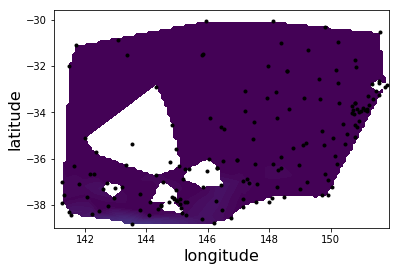

In [194]:
plot_precip(124, [141,152], [-39,-30])

In [ ]:
import xarray as xr

ds = xr.Dataset.from_dataframe(df)
ds.time.encoding['units'] = 'days since 1970-01-01'
ds.time.encoding['standard_name'] = "time"
print(ds.time.encoding)
ds.to_netcdf(path="/Users/pablo/Downloads/010010.nc", mode='w')#, unlimited_dims=["time"])